## Overview
This is a 14-class classification problem.

### Preprocess

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../../CHESTXRAY/Data_Entry_2017.csv')
df = df.sample(frac=1)  # shuffle dataframe
image_dir = '../../images'
image_path = {f:os.path.join(image_dir,f) for f in os.listdir(image_dir)}
print("Scans found: {}, total headers: {}".format(len(image_path), df.shape[0]))
df['path'] = df['Image Index'].map(image_path.get)  # add path column
# note: df['Patient Age'] has value larger than 100
df.sample(3)

Scans found: 112120, total headers: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
74111,00018224_013.png,Infiltration|Pneumothorax,13,18224,59,M,AP,2500,2048,0.168000,0.168000,NaN,../../images/00018224_013.png
28309,00007388_001.png,Effusion,1,7388,40,F,AP,2500,2048,0.168000,0.168000,NaN,../../images/00007388_001.png
107907,00029175_000.png,Infiltration,0,29175,5,F,PA,1712,1502,0.194311,0.194311,NaN,../../images/00029175_000.png


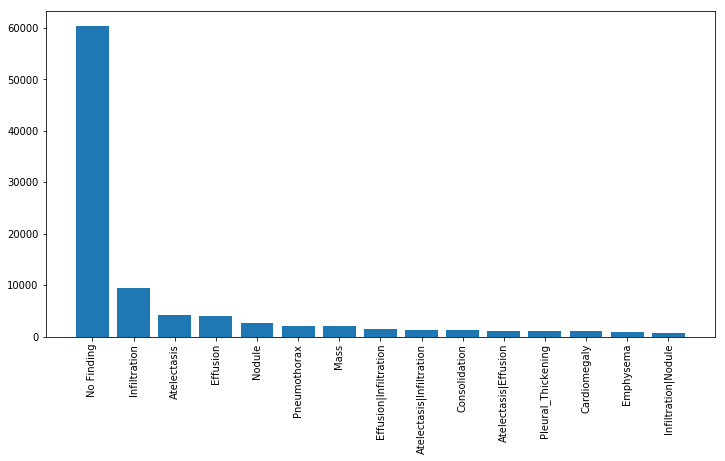

In [4]:
label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 6))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [5]:
from itertools import chain
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(len(all_labels), all_labels)
for c_label in all_labels:
    df[c_label] = df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
df.sample(3)

15 ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
27083,00007055_004.png,No Finding,4,7055,36,F,AP,2500,2048,0.171000,...,0,0,0,0,0,1,0,0,0,0
13864,00003574_002.png,No Finding,2,3574,60,F,PA,1736,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
944,00000231_009.png,Effusion|Fibrosis|Infiltration,9,231,56,F,PA,2834,2701,0.143000,...,0,1,0,1,0,0,0,0,0,0


In [6]:
classes = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
           'Emphysema','Fibrosis','Hernia','Infiltration','Mass','Nodule',
           'Pleural_Thickening','Pneumonia','Pneumothorax']
nb_records, nb_classes = df.shape[0], len(classes)
print(nb_records, nb_classes)

112120 14


In [7]:
train_df = df.iloc[:int(nb_records*0.7)]
valid_df = df.iloc[int(nb_records*0.7):int(nb_records*0.9)]
test_df = df.iloc[int(nb_records*0.9):]
print(train_df.shape, valid_df.shape, test_df.shape)

(78484, 28) (22424, 28) (11212, 28)


### Build and train model

In [8]:
from models import ModelFactory

image_shape = (224, 224, 3)  # input image shape
model = ModelFactory(nb_classes, image_shape).densenet121()
model.summary()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [9]:
from keras.optimizers import Adam

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy")

In [10]:
from class_weights import get_class_weights
class_weights = get_class_weights(df, classes)
print(class_weights)

[{0: 0.10309489832322512, 1: 0.8969051016767748}, {0: 0.024759186585800928, 1: 0.9752408134141991}, {0: 0.0416250445950767, 1: 0.9583749554049233}, {0: 0.020540492329646807, 1: 0.9794595076703532}, {0: 0.11877452729218695, 1: 0.881225472707813}, {0: 0.022440242597217268, 1: 0.9775597574027828}, {0: 0.015037459864430967, 1: 0.984962540135569}, {0: 0.0020246164823403494, 1: 0.9979753835176597}, {0: 0.17743489118801284, 1: 0.8225651088119872}, {0: 0.05156974669996432, 1: 0.9484302533000357}, {0: 0.05646628612201213, 1: 0.9435337138779879}, {0: 0.030190866928291118, 1: 0.9698091330717089}, {0: 0.012763110952550838, 1: 0.9872368890474491}, {0: 0.04728861933642526, 1: 0.9527113806635747}]


In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="weights_{epoch:03d}_{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)
# early = EarlyStopping(monitor="acc", mode="max", patience=3)
reduceLR = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=1, 
                             mode="min", min_lr=1e-8)
callbacks = [checkpoint, reduceLR]

In [12]:
from generator import DataGenerator

batch_size = 32

train_generator = DataGenerator(train_df, path_key="path", classes_key=classes, batch_size=32)
valid_generator = DataGenerator(valid_df, path_key="path", classes_key=classes, batch_size=32, shuffle=False)

In [ ]:
nb_epoch = 200
history = model.fit_generator(generator=train_generator, 
                              epochs=nb_epoch, 
                              validation_data=valid_generator, 
                              callbacks=callbacks, 
                              class_weight=class_weights, 
                              workers=6, 
                              shuffle=False)